2개의 특성과 3개의 라벨로 분류 문제 

- label 개수: 3개 (ToVol) 
- feature 개수 : 2개(Speed, OccRate)
- DNN, SVC, VQC, QSVC 성능 비교

In [1]:
import datetime
import time
import qiskit
import tensorflow 
import platform

datetime.datetime.now()

print('qiskit version:', qiskit.__version__)
print('tf     version:', tensorflow.__version__)
print('Python Version:',platform.python_version())
print('OS            :', platform.system())
print('코딩시간       :', time.strftime("%a %b %d %H:%M:%S %Y %Z"))
print('Copyright     : Hongsuk (hongsuk.yi@gmail.com)')

qiskit version: 1.4.1
tf     version: 2.18.0
Python Version: 3.10.0
OS            : Windows
코딩시간       : Mon Mar 10 21:10:41 2025 대한민국 표준시
Copyright     : Hongsuk (hongsuk.yi@gmail.com)


In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
#sklearn
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
from mlxtend.plotting import plot_decision_regions

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam 

## 포팅

In [5]:
# from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.optimizers import SPSA, L_BFGS_B, COBYLA
from qiskit_machine_learning.algorithms import VQC, QSVC, NeuralNetworkClassifier 

from qiskit.primitives import Sampler

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, ZFeatureMap, EfficientSU2, TwoLocal
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.utils import algorithm_globals

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv("https://raw.githubusercontent.com/hongsukyi/Lectures/main/data/vds16.csv")

## Feature selection

In [17]:
df=df[:1000]

In [42]:
s1= 45
s2= 52 
v1=100
v2=10

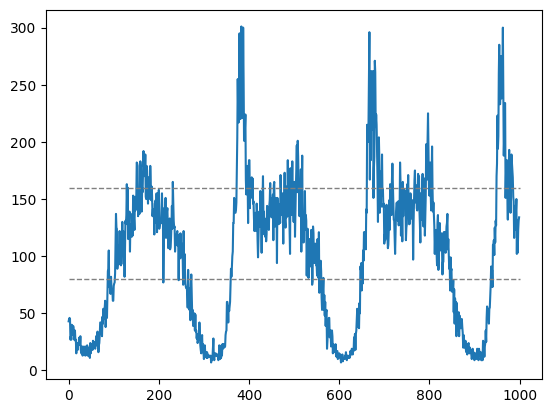

In [43]:
#plt.plot(df["OccRate"]*8)
plt.plot(df["ToVol"])
#plt.plot(df["Speed"]*df["ToVol"])
plt.hlines(v1, 0,len(df), color='gray', linestyle='--', linewidth=1)
plt.hlines(v2, 0,len(df),color='gray', linestyle='--', linewidth=1)

<Axes: xlabel='label', ylabel='count'>

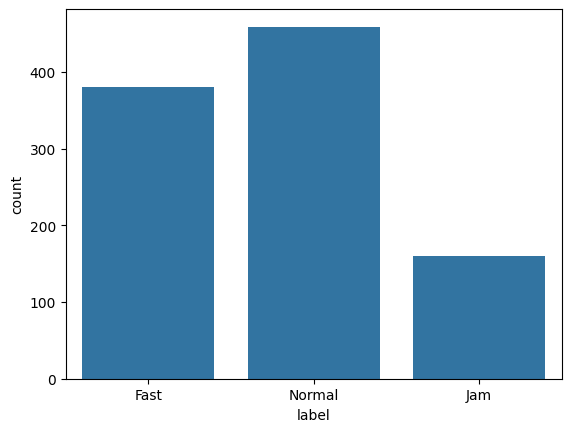

In [44]:
num_classes = 3

def label_Vol(x):
    if ( x < v1):
        label = 'Fast'
    elif (x > v2) :
        label = 'Jam'
    else :
        label = 'Normal'
    return label

df["label"] = df["ToVol"].apply(lambda x: label_Vol(x))
sns.countplot(x="label", data=df)

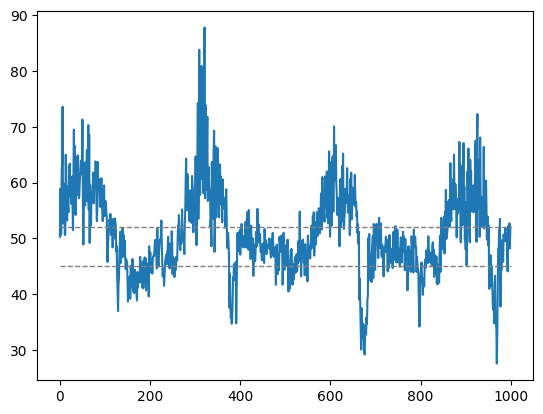

In [35]:
plt.plot(df["Speed"][0:len(df)],label='ToVol')
#plt.plot(df["Speed"][0:800],label='ToVol')
plt.hlines(s1, 0,len(df), color='gray', linestyle='--', linewidth=1)
plt.hlines(s2, 0,len(df),color='gray', linestyle='--', linewidth=1)

<Axes: xlabel='label', ylabel='count'>

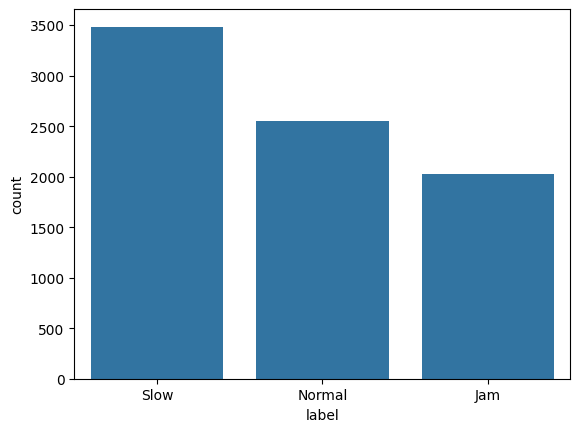

In [ ]:
def strategy_label(idx):
    if ( idx < v1):
        label = 'Jam'
    elif (idx > v2) :
        label = 'Normal'
    else :
        label = 'Slow'
    return label

df["label"] = df["Speed"].apply(lambda x: strategy_label(x))
sns.countplot(x="label", data=df)

<Axes: xlabel='OccRate', ylabel='ToVol'>

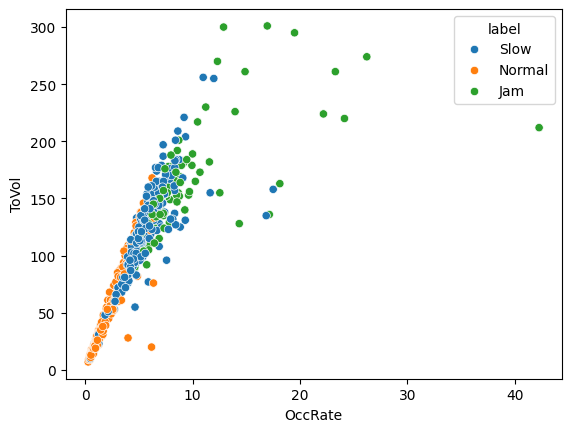

In [13]:
sns.scatterplot(data=df[:576], x = 'OccRate', y = 'ToVol', hue='label') 

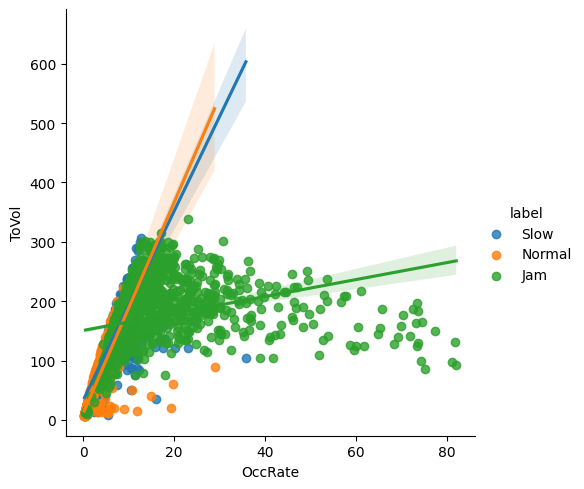

In [14]:
sns.lmplot(x="OccRate", y="ToVol", hue="label", data=df)

In [15]:
df.columns

Index(['Date', 'ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed', 'OccRate',
       'label'],
      dtype='object')

In [16]:
# classical SVM
X = df[['OccRate', 'ToVol']]
y = df['label']

In [17]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
X_scaled = StandardScaler().fit_transform(X)
print(X_scaled.shape)
print(X_scaled[:5,:])

(8064, 2)
[[-0.6331216  -1.05487777]
 [-0.6420243  -1.02360358]
 [-0.63757295 -1.00796648]
 [-0.6598297  -1.02360358]
 [-0.74885671 -1.30507134]]


In [18]:
y_enc = LabelEncoder().fit_transform(y)
y_enc[:100]

array([2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.20)

# Classical classifiers 

## SVM

In [20]:
acc_sv=acc_ann=acc_dnn=acc_qsvc=acc_vqc=0.0

In [21]:
# Create svm Classifier
ClassifierSVM = SVC()
ClassifierSVM.fit(X_train, y_train)

SVC()

In [22]:
y_pred = ClassifierSVM.predict(X_test)
acc_svc = metrics.accuracy_score(y_test, y_pred)
print("\n- Accuracy of Classical SVC:",acc_svc)
print('\n- Confustion Matrix:\n', metrics.confusion_matrix(y_test,y_pred))
print('\n- Classification Report:\n',metrics.classification_report(y_test, y_pred))


- Accuracy of Classical SVC: 0.7650340979541228

- Confustion Matrix:
 [[219   3 186]
 [  0 458  71]
 [ 43  76 557]]

- Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.54      0.65       408
           1       0.85      0.87      0.86       529
           2       0.68      0.82      0.75       676

    accuracy                           0.77      1613
   macro avg       0.79      0.74      0.75      1613
weighted avg       0.78      0.77      0.76      1613



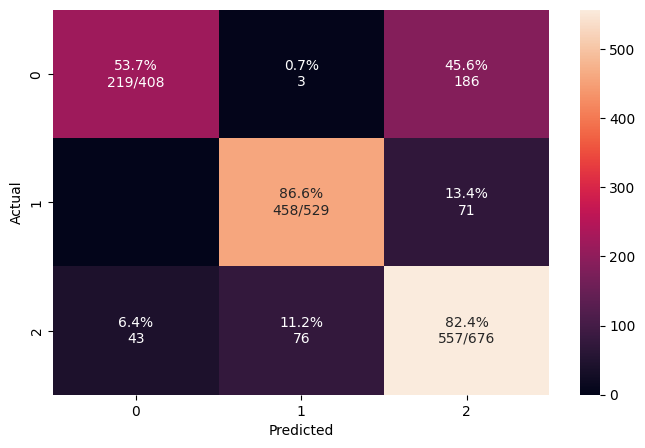

In [23]:
# confusion matrix of SVM
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, y_pred, labels=None, ymap=None, figsize=(8,5)) 

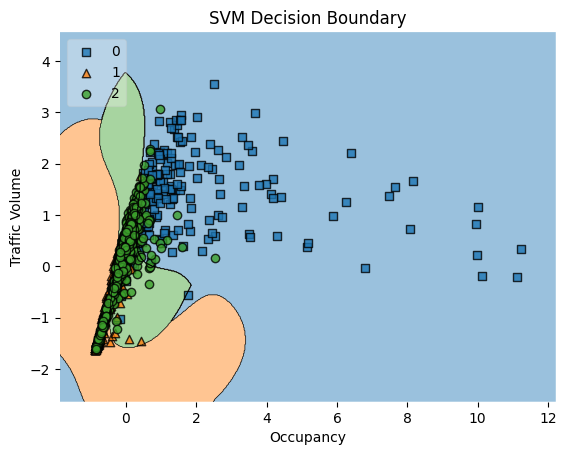

In [24]:
plot_decision_regions(X_test, y_test, clf=ClassifierSVM, legend=2)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('SVM Decision Boundary')
plt.show()


## ANN

In [25]:
# classical QNN 
model_ann = MLPClassifier(max_iter=1000,  random_state=5)
model = model_ann
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Final prediction score: [%.8f]' % accuracy_score(y_test, y_pred))

Final prediction score: [0.79169250]


In [26]:
# classification report of ANN
y_pred = model.predict(X_test) 

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(y_test,y_pred))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test,y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.65      0.71       408
           1       0.87      0.91      0.89       529
           2       0.74      0.79      0.76       676

    accuracy                           0.79      1613
   macro avg       0.80      0.78      0.79      1613
weighted avg       0.79      0.79      0.79      1613

Confusion matrix: 
 [[265   2 141]
 [  0 480  49]
 [ 73  71 532]]


In [27]:
y_pred = model.predict(X_test)
acc_ann = metrics.accuracy_score(y_test, y_pred)
print("\n- Accuracy of Classical SVC:",acc_ann)
print('\n- Confustion Matrix:\n', metrics.confusion_matrix(y_test,y_pred))
print('\n- Classification Report:\n',metrics.classification_report(y_test, y_pred))


- Accuracy of Classical SVC: 0.791692498450093

- Confustion Matrix:
 [[265   2 141]
 [  0 480  49]
 [ 73  71 532]]

- Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.65      0.71       408
           1       0.87      0.91      0.89       529
           2       0.74      0.79      0.76       676

    accuracy                           0.79      1613
   macro avg       0.80      0.78      0.79      1613
weighted avg       0.79      0.79      0.79      1613



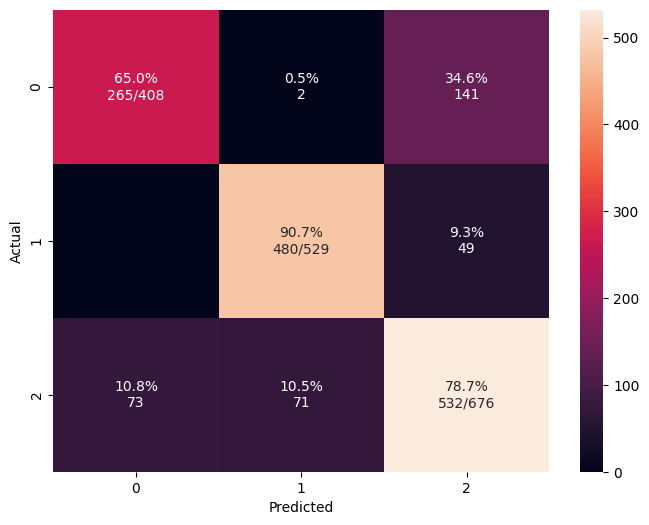

In [28]:
# confusion matrix of ANN
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(5,4)): 
    if ymap is not None: 
        y_pred = [ymap[yi] for yi in y_pred] 
        y_true = [ymap[yi] for yi in y_true] 
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    cm_sum = np.sum(cm, axis=1, keepdims=True) 
    cm_perc = cm / cm_sum.astype(float) * 100 
    annot = np.empty_like(cm).astype(str) 
    nrows, ncols = cm.shape 
    for i in range(nrows): 
        for j in range(ncols): 
            c = cm[i, j] 
            p = cm_perc[i, j] 
            if i == j: 
                s = cm_sum[i] 
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s) 
            elif c == 0: 
                annot[i, j] = '' 
            else: 
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels) 
    cm.index.name = 'Actual' 
    cm.columns.name = 'Predicted' 
    fig, ax = plt.subplots(figsize=figsize) 
    sns.heatmap(cm, annot=annot, fmt='', ax=ax) 
    
cm_analysis(y_test, y_pred,labels=None, ymap=None, figsize=(8,6)) 

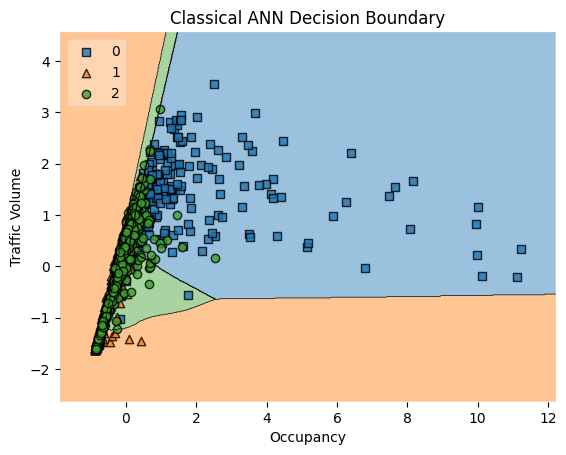

In [29]:
plot_decision_regions(X_test, y_test, clf=model_ann, legend=2)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('Classical ANN Decision Boundary')
plt.show()

## Deep Neural Network MLP

In [30]:
X_train.shape, num_classes

((6451, 2), 3)

In [31]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation = 'relu'),
    Dense(32, activation= 'relu'),
    Dense(num_classes, activation= 'softmax')])  

In [32]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = 'adam', metrics = ['accuracy'])

In [33]:
history = model.fit(X_train,y_train, epochs=50, batch_size=32, validation_split=0.2)
#history = model.fit(X_train, epochs=50)

Epoch 1/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5653 - loss: 0.9302 - val_accuracy: 0.7436 - val_loss: 0.6122
Epoch 2/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7280 - loss: 0.6235 - val_accuracy: 0.7498 - val_loss: 0.5809
Epoch 3/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7385 - loss: 0.5864 - val_accuracy: 0.7699 - val_loss: 0.5549
Epoch 4/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7553 - loss: 0.5696 - val_accuracy: 0.7777 - val_loss: 0.5337
Epoch 5/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7586 - loss: 0.5468 - val_accuracy: 0.7878 - val_loss: 0.5163
Epoch 6/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7675 - loss: 0.5268 - val_accuracy: 0.7994 - val_loss: 0.5015
Epoch 7/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7759 - loss: 0.5090 - val_accuracy: 0.7955 - val_loss: 0.5043
Epoch 8/50
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7772 - loss: 0.5200 - val_accuracy: 0.

In [34]:
_, acc_dnn = model.evaluate(X_test,y_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7918 - loss: 0.4701 


In [35]:
print("\n- Accuracy of Classical DNN:",acc_dnn)


- Accuracy of Classical DNN: 0.7817730903625488


In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

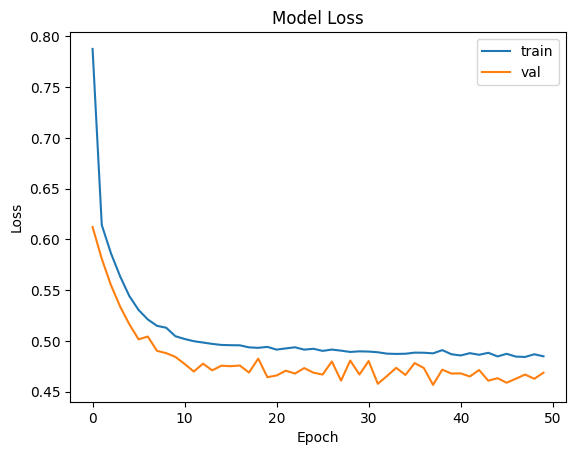

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

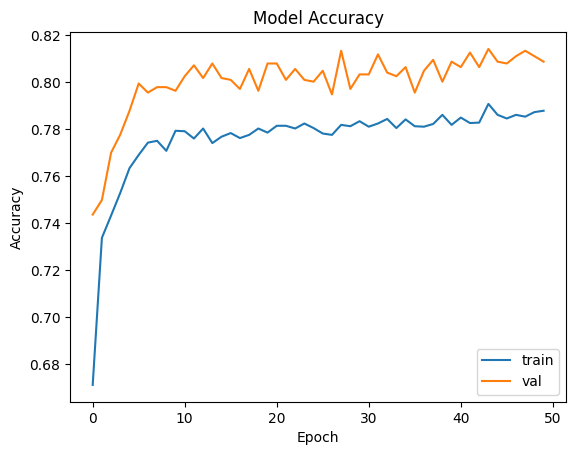

In [38]:
# 훈련 정확도 그래프
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [39]:
class Onehot2Int(object):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)   

model_one =Onehot2Int(model)

9600/9600 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


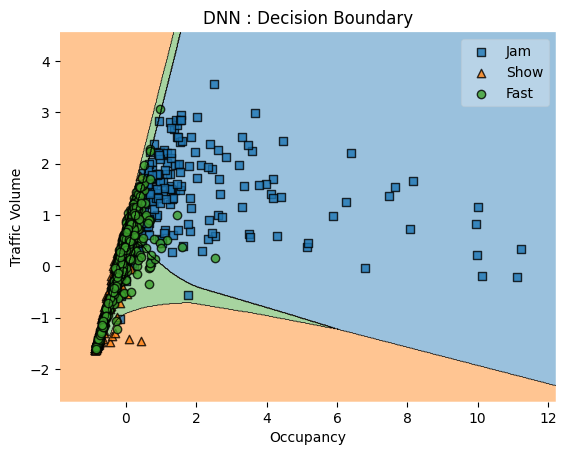

In [40]:
ax=plot_decision_regions(X_test, y_test, clf=model_one)
plt.xlabel('Occupancy')
plt.ylabel('Traffic Volume')
plt.title('DNN : Decision Boundary')
handles, labels = ax.get_legend_handles_labels()
if num_classes == 3 : 
    ax.legend(handles, [ 'Jam', 'Show', 'Fast'],  framealpha=0.3, scatterpoints=1)
plt.show()

# Quantum Simulator for Quantum Classification

In [41]:
import time
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit.circuit.library import ZZFeatureMap,  RealAmplitudes
# from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler

### 1) VQC

feature map
- from classical data to qubit through data encoding, data embedding, data loading
- The most standard fearture is ZZFeatureMap

ansatz

- apply a parameterize quantum circuit.
- objective function characterized the distance between the prediction and known labeled data.
- A parametrized quantum circuit is call a paramenterized trial state, variational form, or ansatz.- 

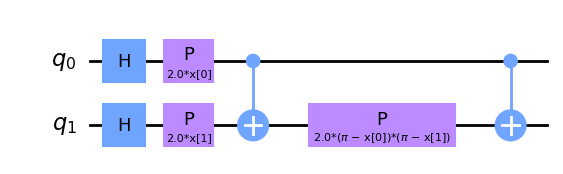

In [42]:
feature_map = ZZFeatureMap(feature_dimension = X_train.shape[1], reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

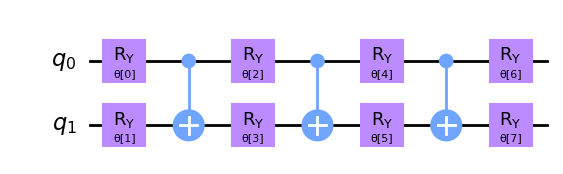

In [43]:
ansatz = RealAmplitudes(num_qubits = X_train.shape[1], reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

StatevectorSampler를 이용한 Simulator

In [44]:
sampler = Sampler()

콜백함수에는 
- weights
- objective function values

In [45]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Onh-hot encoded format의 경우 crossEntropyLoss를 사용한다.

In [46]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer = COBYLA(maxiter=100),
    callback=callback_graph,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


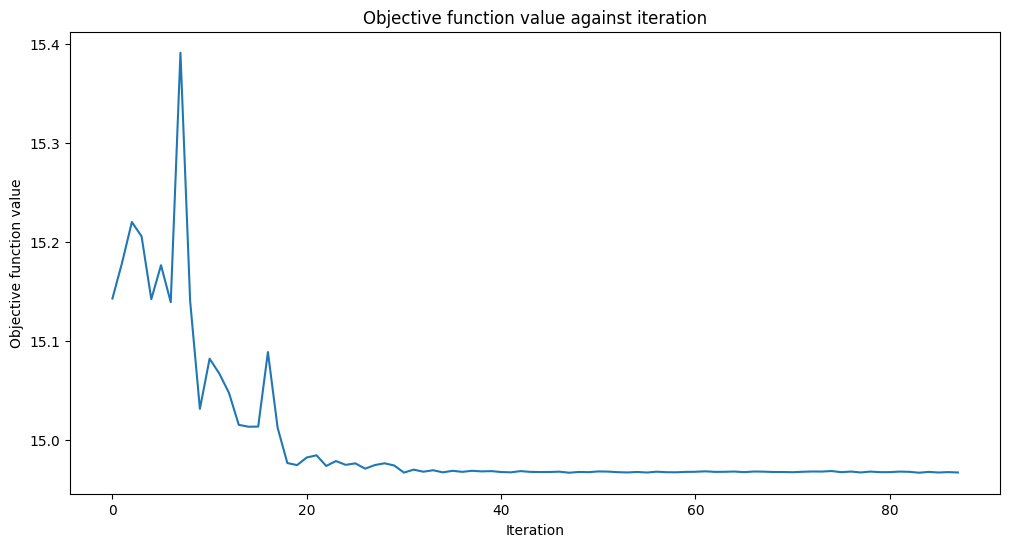

Training time: 7169 seconds


In [47]:
plt.rcParams["figure.figsize"] = (12, 6)

# clear objective value history
objective_func_vals = []
start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [48]:
train_score_q4 = vqc.score(X_train, y_train)
acc_vqc = vqc.score(X_test, y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset    : {acc_vqc:.2f}")

Quantum VQC on the training dataset: 0.36
Quantum VQC on the test dataset    : 0.38


In [49]:
vals=objective_func_vals;vals

[15.142830994941942,
 15.179267271033101,
 15.220261975556513,
 15.205695370380463,
 15.142138242547826,
 15.176531258093135,
 15.139151274664247,
 15.391556054003585,
 15.13999404673269,
 15.031206761610822,
 15.08192514620484,
 15.066858117777072,
 15.047154757299312,
 15.01500456030709,
 15.013089600330414,
 15.013234814412229,
 15.088675394360182,
 15.012012791541446,
 14.976323290178732,
 14.974250927722455,
 14.981962387464472,
 14.984175597508722,
 14.97337507953973,
 14.978363712408614,
 14.974515858703521,
 14.97601908474071,
 14.970649475086297,
 14.974280188755033,
 14.976091887776102,
 14.973852743351491,
 14.966648630025,
 14.969658084126152,
 14.967578618483389,
 14.969054587816725,
 14.966912362513755,
 14.96848441601791,
 14.967416028332973,
 14.96850025795096,
 14.96788187472418,
 14.96817597265101,
 14.967256306802618,
 14.966931391369668,
 14.968168602064509,
 14.967396102817178,
 14.967219115096377,
 14.967283664212099,
 14.967592451444958,
 14.966543693148699,
 14.

In [50]:
pd.DataFrame(vals,columns=['loss']).to_csv('cost_vqc.csv')
hist=pd.read_csv('cost_vqc.csv')

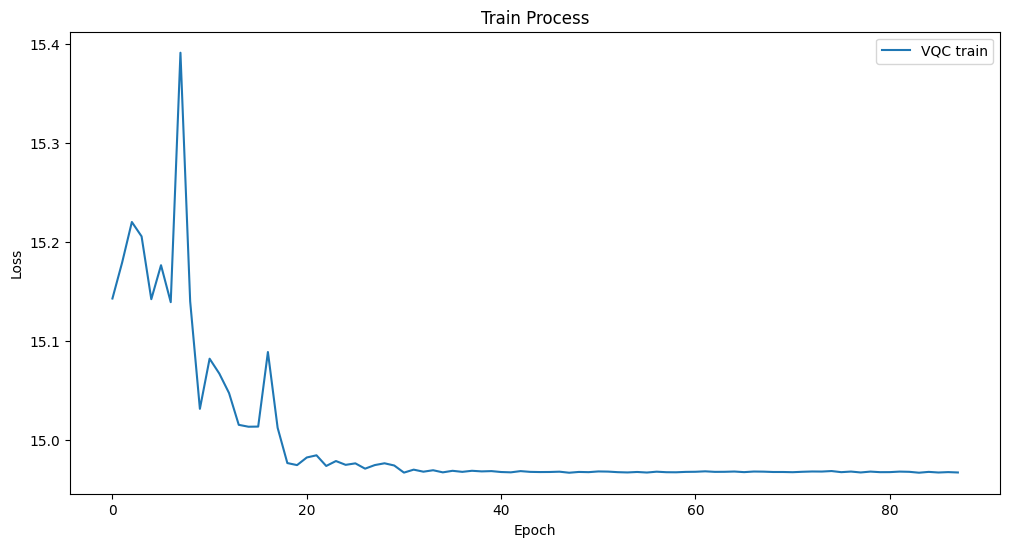

In [51]:
# 훈련 정확도 그래프
#plt.plot(objective_func_vals)
plt.plot(hist['loss'])
plt.title('Train Process')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['VQC train'])
plt.show()

VQC performance

In [52]:
# classification report of VQC

y_pred = vqc.predict(X_test)

# print classification report and confusion matrix for the classifier
print("Classification report: \n", metrics.classification_report(y_test, y_pred))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.31      0.31      0.31       408
           1       0.40      0.90      0.55       529
           2       0.00      0.00      0.00       676

    accuracy                           0.37      1613
   macro avg       0.23      0.40      0.29      1613
weighted avg       0.21      0.37      0.26      1613

Confusion matrix: 
 [[128 280   0]
 [ 55 474   0]
 [234 442   0]]


In [53]:
predict = vqc.predict(X_test)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_test}")

Predicted labels: [1 0 0 ... 0 1 0]
Ground truth:     [2 2 1 ... 0 2 0]


<Axes: xlabel='models'>

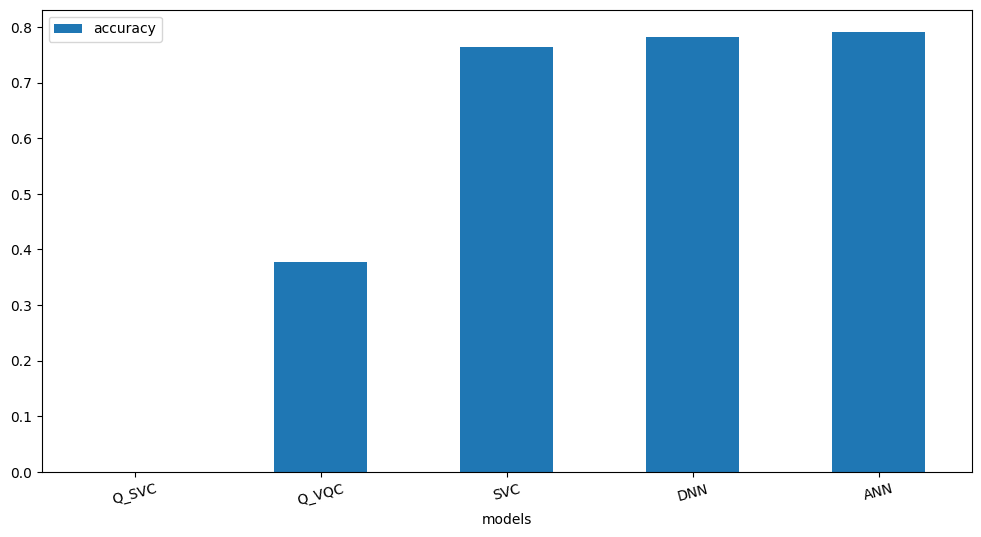

In [54]:
df = pd.DataFrame({
    'models': ['SVC', 'ANN','DNN','Q_SVC', 'Q_VQC'],
    'accuracy':[acc_svc, acc_ann, acc_dnn, acc_qsvc, acc_vqc]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)

### 2) Quantum SVC

In [55]:
fm_qsvc = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2, entanglement="linear")
fm_qsvc.decompose().draw(output="mpl", style="clifford", fold=20)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
qsvc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=fm_qsvc)
qsvc = QSVC(quantum_kernel=qsvc_kernel)

In [ ]:
start = time.time()
qsvc.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [ ]:
acc_qsvc = qsvc.score(X_test, y_test)
print(f"QSVC classification test score: {acc_qsvc}")

In [ ]:
df = pd.DataFrame({
    'models': ['SVC', 'ANN','DNN','Q_SVC', 'Q_VQC'],
    'accuracy':[acc_svc, acc_ann, acc_dnn, acc_qsvc, acc_vqc]})
df=df.sort_values(by='accuracy', ascending=True)

df.plot.bar(x='models',y='accuracy',rot=15)

In [ ]:
# classification report of QSVC
y_pred = qsvc.predict(X_test) 
metrics.classification_report(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)